In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

from scipy.special import gamma
from time import time
from datetime import datetime

## Auxiliary constants

In [2]:
european_call_ref = 0.056832
variance_swap_price_ref = 0.028295
variance_call_price_ref = 0.013517

In [3]:
S_n_const = "S_n"
V_n_const = "V_n"
X_n_const = "X_n"

In [4]:
M = 10**3

l = 0.3
nu = 0.3
theta = 0.02
rho = -0.7
H = 0.1

K = 1

V_0 = 0.02
S_0 = 1
Y_0 = np.log(S_0)

In [5]:
T = 1

In [6]:
number_of_iterations = 7
n_initial = 4

## Kernel

In [7]:
def K_t(t):

    if t == 0:
        return 0
    
    return t**(H-0.5)/gamma(H+0.5)

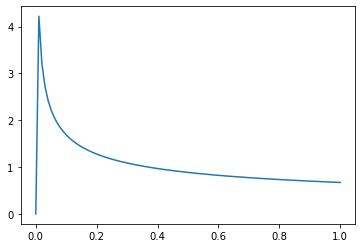

In [8]:
n = 100
t = [k*T/(n-1) for k in range(n)]
K_arr = []

for k in range(np.size(t)):
    K_arr.append(K_t(t[k]))
    
    if K_t(t[k])<0:
        print(f"Problem is here: K({t[k]})={K_arr[k]}")
    
plt.plot(t, K_arr)
plt.show()

## Payoff functions

In [9]:
def european_call_options(x):
    if type(x) != np.ndarray and type(x) != list:
        raise Exception(f"type(x) != list\n type(x)={type(x)}")
        
    return np.maximum(x[-1]-K,0)

def asian_options(x):
    A_T = T*np.mean(x)
    
    return np.maximum(A_T-K,0)

def lookback_options(x):
    M_T = np.max(x)
    
    return np.maximum(M_T-K,0)

def variance_swap_price(x):
    if type(x) is np.ndarray or type(x) is list:
        return x[-1]
        
    return x

def variance_call_price(x):
    if type(x) is np.ndarray or type(x) is list:
        return np.maximum(x[-1]-V_0,0)
        
    return np.maximum(x-V_0,0)

## Utility methods for displaying data

In [10]:
def plot_estimations(scheme_8_data, scheme_9_data, title="E[f(S,X)]", ref_value=None):
    integers1toN = scheme_8_data['n']
    
    fig, ax = plt.subplots()

    ax.plot(integers1toN, scheme_8_data['U_M'], label='Scheme (9)', color="blue")
    ax.fill_between(integers1toN, np.array(scheme_8_data['U_M']) - np.array(scheme_8_data['error']), 
                    np.array(scheme_8_data['U_M']) + np.array(scheme_8_data['error']), label='Confidence interval', 
                    color='blue', alpha=.1)
    
    ax.plot(integers1toN, scheme_9_data['U_M'], label='Scheme (10)', color="orange")
    ax.fill_between(integers1toN, np.array(scheme_9_data['U_M']) - np.array(scheme_9_data['error']), 
                    np.array(scheme_9_data['U_M']) + np.array(scheme_9_data['error']), label='Confidence interval', 
                    color='orange', alpha=.1)

    if ref_value != None:
        ax.axhline(ref_value, label='reference value', color="green", linestyle='--')
    
    ax.legend(loc=1)
    
    plt.title(f"Estimation of {title}")
    plt.xlabel("Number of steps")
    plt.ylabel("Estimation")
    
    plt.show()

    
def show_numerical_results_table(scheme_8_results, scheme_9_results, ref_value=None):
    table_size = np.minimum(np.size(scheme_8_results['U_M']),np.size(scheme_9_results['U_M']))
    
    print("\tEstimation of E[f] with Scheme (9) (left) and Scheme (10) (right). The computation time is in seconds.")
    print()
    print("\tMean Value\t Stat.Error\t Comp.Time\t||\t Mean Value\t Stat.Error\t Comp.Time")
    
    if ref_value != None:
        print(f"Ref\t {ref_value}")
        print()
        
    for k in range(table_size):
        print(f"n={scheme_8_results['n'][k]}\t",
            f"{scheme_8_results['U_M'][k]:f}\t",
            f"{scheme_8_results['error'][k]:f}\t",
            f"{scheme_8_results['time'][k]:f}\t||\t",
            f"{scheme_9_results['U_M'][k]:f}\t",
            f"{scheme_9_results['error'][k]:f}\t",
            f"{scheme_9_results['time'][k]:f}")


In [11]:
def stats_n(data):

    U_M = np.mean(data)
    var_M = np.var(data)
    
    error = 2*var_M/np.sqrt(M)
    confidence_interval = [U_M - error, U_M + error]

    return {"U_M": U_M,
            "var_M": var_M,
            "error": error,
            "confidence_interval": confidence_interval}

In [12]:
def generate_subdivision(t):

    t_size = np.size(t)
    t_temp = t
    
    for k in range(0,t_size-1):
        t = np.insert(t, 2*k+1, (t_temp[k+1]+t_temp[k])/2)
        
    return t

def generate_BM(t,W,W_orth,n=n_initial):

    if np.size(W)==0 or np.size(W_orth)==0:
        if np.size(t) != n:
            raise Exception(f"np.size(t) != n_initial\n np.size(t)={np.size(t)},n_initial={n}")
            
        G1 = np.random.randn(n)
        G2 = np.random.randn(n)
        
        W.append(0)
        W_orth.append(0)
        
        for i in range(n-1):
            W.append(W[i] + np.sqrt(t[i+1] - t[i])*G1[i])
            W_orth.append(W_orth[i] + np.sqrt(t[i+1] - t[i])*G2[i])
        
        return W, W_orth

    W_temp = W
    W_orth_temp = W_orth
    
    N = np.size(t)
    
    for i in range(1,N,2):
        
        var = (t[i+1] - t[i-1])/4
        
        W_k = np.random.normal((W[i-1]+W[i])/2, np.sqrt(var))
        W_orth_k = np.random.normal((W_orth[i-1]+W_orth[i])/2, np.sqrt(var))
        
        W_temp.insert(i,W_k)
        W_orth_temp.insert(i,W_orth_k)

    return W_temp, W_orth_temp

### Validity of Brownian motion & Brownian bridge

We check the convergence of variance of increments of Brownian motion.

### Brownian motion demo

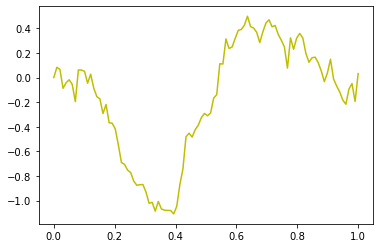

In [13]:
n_test = 100
t_test = [k*T/(n_test-1) for k in range(n_test)]
w, _ = generate_BM(t_test,[],[],n_test)

plt.plot(t_test, w, color="y")
plt.show()

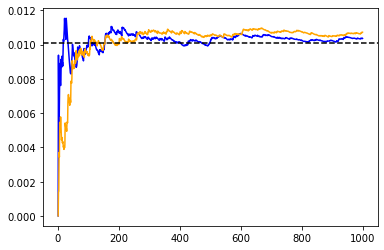

In [14]:
n_test = 100
t_test = [k*T/(n_test-1) for k in range(n_test)]
bm = 10**3

e1 = []
e2 = []

for m in range(bm):
    w1, w2 = generate_BM(t_test,[],[],n_test)
    
    e1.append(w1[-1]-w1[-2])
    e2.append(w2[-1]-w2[-2])

bm_range = np.arange(1,bm+1)

t_delta = t_test[1]-t_test[0]

var1 = np.cumsum(np.power(e1,2))/bm_range-(np.cumsum(e1)/bm_range)**2
var2 = np.cumsum(np.power(e2,2))/bm_range-(np.cumsum(e2)/bm_range)**2

plt.plot(bm_range, var1, color="blue")
plt.plot(bm_range, var2, color="orange")

plt.axhline(t_delta, color="black", linestyle='--')
plt.show()

### Brownian bridge demo

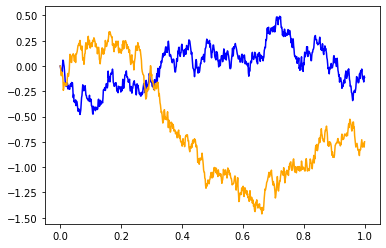

In [15]:
n_test = 7
t_test = [k*T/(n_test-1) for k in range(n_test)]

w1, w2 = generate_BM(t_test,[],[],n_test)

for i in range(n_test):
    t_test = generate_subdivision(t_test)
    w1, w2 = generate_BM(t_test,w1,w2)

plt.plot(t_test, w1, color="blue")
plt.plot(t_test, w2, color="orange")
plt.show()

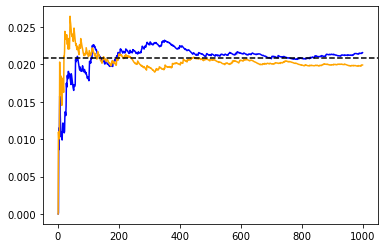

In [16]:
n_test = 4
n = 4

bm = 10**3

e1 = []
e2 = []

for m in range(bm):
    t_test = [k*T/(n_test-1) for k in range(n_test)]
    w1, w2 = generate_BM(t_test,[],[],n_test)

    for i in range(4):

        t_test=generate_subdivision(t_test)
        w1, w2 = generate_BM(t_test,w1,w2)
        
    e1.append(w1[-1]-w1[-2])
    e2.append(w2[-1]-w2[-2])

bm_range = np.arange(1,bm+1)

t_delta = t_test[1]-t_test[0]

var1 = np.cumsum(np.power(e1,2))/bm_range-(np.cumsum(e1)/bm_range)**2
var2 = np.cumsum(np.power(e2,2))/bm_range-(np.cumsum(e2)/bm_range)**2

plt.plot(bm_range, var1, color="blue")
plt.plot(bm_range, var2, color="orange")

plt.axhline(t_delta, color="black", linestyle='--')
plt.show()

# Main algorithms

## Euler scheme for (S,V) process

In [17]:
def S_V_process(t,W,W_orth):

    n = np.size(t)

    Y_n = np.zeros(n)
    V_n = np.zeros(n)
    S_n = np.zeros(n)

    S_n[0] = S_0
    Y_n[0] = Y_0
    V_n[0] = V_0

    t_delta = t[1] - t[0]

    for k in range(1,n):

        V_sum = 0
        for i in range(k):
            v_max = np.maximum(V_n[i],0)
            V_sum += ((K_t(t[k]-t[i])*(-l*v_max*t_delta 
                                       + nu*np.sqrt(v_max)*(W[i+1] - W[i]))))

        K_integral = integrate.quad(lambda s: theta*K_t(t[k]-s), 0, t[k])[0]
        V_n[k] = V_0 + V_sum + K_integral

        v_max = np.maximum(V_n[k-1],0)
        Y_n[k] = Y_n[k-1] + (-0.5*v_max*t_delta + rho*np.sqrt(v_max)*(W[k] - W[k-1]) 
                  + np.sqrt(1 - rho**2)*np.sqrt(v_max)*(W_orth[k] - W_orth[k-1]))

    S_n = np.exp(Y_n)
    
    return {"V_n": V_n,
            "S_n": S_n}


## Euler scheme for (S,X) process

In [18]:
def S_X_process(t,W,W_orth):
    
    n = np.size(t)
    
    Y_n = np.zeros(n)
    X_n = np.zeros(n)
    X_n_max = np.zeros(n)
    
    S_n = np.zeros(n)

    M_n = np.zeros(n)
    M_n_orth = np.zeros(n)

    Y_n[0] = Y_0
    S_n[0] = S_0
   
    t_delta = t[1] - t[0]
        
    for k in range(1,n):

        X_sum = 0
        for i in range(k):
            X_sum += (-l*X_n_max[i] + nu*M_n[i])*t_delta*K_t(t[k] - t[i])

        K_integral = integrate.quad(lambda s: theta*s*K_t(t[k]-s), 0, t[k])[0]
        
        X_n[k] = V_0*t[k] + X_sum + K_integral
        X_n_max[k] = np.max(X_n)

        M_n[k] = M_n[k-1] + np.sqrt(X_n_max[k] - X_n_max[k-1])*(W[k] - W[k-1])/np.sqrt(t[k]-t[k-1])
        M_n_orth[k] = M_n_orth[k-1] + np.sqrt(X_n_max[k] - X_n_max[k-1])*(W_orth[k] - W_orth[k-1])/np.sqrt(t[k]-t[k-1])
        
        Y_n[k] = Y_0 - 0.5*X_n_max[k] + rho*M_n[k] + np.sqrt(1 - rho**2)*M_n_orth[k]
        
    S_n = np.exp(Y_n)
    
    return {"S_n": S_n,
            "X_n": X_n}


## Evaluation algorithms

In [19]:
def scheme_8(f, variable, n=None):
    
    iterations = number_of_iterations
    N = n_initial
    
    if n != None:
        iterations = 1
        N = n
        
    t = [k*T/(N-1) for k in range(N)]

    W_M = [0]*M
    W_orth_M = [0]*M

    for m in range(M):
        W, W_orth = generate_BM(t,[],[],N)

        W_M[m] = W
        W_orth_M[m] = W_orth
 
    final_result = {key: [] for key in ["U_M","n","time","var_M","confidence_interval","error","cum_sum_n"]}
    evaluate = None
    
    for n in range(iterations):

        t_0 = time()

        t_delta = t[1]-t[0]

        f_n_M = np.zeros(M)

        for m in range(M):

            result_sv = S_V_process(t,W_M[m],W_orth_M[m])

            S_n = result_sv["S_n"]
            V_n = result_sv["V_n"]
            X_n = sum(V_n)*t_delta
            
            if variable == S_n_const:
                evaluate = S_n
            elif variable == V_n_const:
                evaluate = V_n
            elif variable == X_n_const:
                evaluate = X_n
            else:
                raise Exception(f"Wrong variable call: {variable}")

            f_n_M[m] = f(evaluate)

            t_new = generate_subdivision(t)
            W_M[m], W_orth_M[m] = generate_BM(t_new,W_M[m],W_orth_M[m])

        
        t_1 = time()
        
        n_result = stats_n(f_n_M)

        final_result["U_M"].append(n_result["U_M"])
        final_result["error"].append(n_result["error"])
        final_result["var_M"].append(n_result["var_M"])
        final_result["confidence_interval"].append(n_result["confidence_interval"])
        final_result["time"].append(t_1 - t_0)
        final_result["n"].append(np.size(t))

        t = generate_subdivision(t)

    return final_result

In [20]:
def scheme_9(f, variable, n=None):
    
    iterations = number_of_iterations
    N = n_initial
    
    if n != None:
        iterations = 1
        N = n
        
    t = [k*T/(N-1) for k in range(N)]

    W_M = [0]*M
    W_orth_M = [0]*M

    for m in range(M):
        W, W_orth = generate_BM(t,[],[],N)

        W_M[m] = W
        W_orth_M[m] = W_orth
        
    final_result = {key: [] for key in ["U_M","n","time","var_M","confidence_interval","error","cum_sum_n"]}

    evaluate = None
        
    for n in range(iterations):

        t_0 = time()

        f_n_M = np.zeros(M)
        
        for m in range(M):
            result_sv = S_X_process(t,W_M[m],W_orth_M[m])

            S_n = result_sv["S_n"]
            X_n = result_sv["X_n"]
            
            if variable == S_n_const:
                evaluate = S_n
            elif variable == X_n_const:
                evaluate = X_n
            else:
                raise Exception(f"Wrong variable call: {variable}")

            f_n_M[m] = f(evaluate)
            
            W_M[m], W_orth_M[m] = generate_BM(generate_subdivision(t),W_M[m],W_orth_M[m])
        
        t_1 = time()
        
        n_result = stats_n(f_n_M)

        final_result["U_M"].append(n_result["U_M"])
        final_result["error"].append(n_result["error"])
        final_result["var_M"].append(n_result["var_M"])
        final_result["confidence_interval"].append(n_result["confidence_interval"])
        final_result["time"].append(t_1 - t_0)
        final_result["n"].append(np.size(t))
        
        t = generate_subdivision(t)

    return final_result

# Numerical experiments

## _European call_ maximum(S_T-K,0)

In [21]:
scheme_8_results = scheme_8(european_call_options, S_n_const)
scheme_9_results = scheme_9(european_call_options, S_n_const)

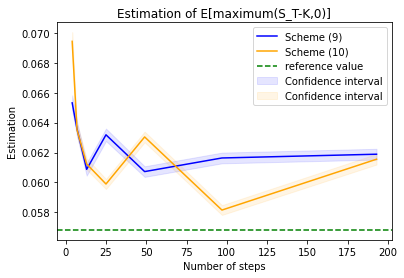

	Estimation of E[f] with Scheme (9) (left) and Scheme (10) (right). The computation time is in seconds.

	Mean Value	 Stat.Error	 Comp.Time	||	 Mean Value	 Stat.Error	 Comp.Time
Ref	 0.056832

n=4	 0.065320	 0.000501	 0.854260	||	 0.069431	 0.000608	 0.950815
n=7	 0.063594	 0.000472	 2.150824	||	 0.063523	 0.000419	 2.363005
n=13	 0.060880	 0.000423	 4.435348	||	 0.061235	 0.000374	 4.755877
n=25	 0.063186	 0.000416	 9.351788	||	 0.059899	 0.000337	 9.631534
n=49	 0.060729	 0.000354	 20.984579	||	 0.063044	 0.000356	 20.109801
n=97	 0.061639	 0.000358	 52.080128	||	 0.058158	 0.000327	 43.747607
n=193	 0.061890	 0.000362	 143.346604	||	 0.061555	 0.000355	 101.841037


In [22]:
plot_estimations(scheme_8_results, scheme_9_results, "E[maximum(S_T-K,0)]", european_call_ref)
show_numerical_results_table(scheme_8_results ,scheme_9_results, european_call_ref)

## _Asian option_ maximum(A_T-K,0)

In [23]:
scheme_8_results = scheme_8(asian_options, S_n_const)
scheme_9_results = scheme_9(asian_options, S_n_const)

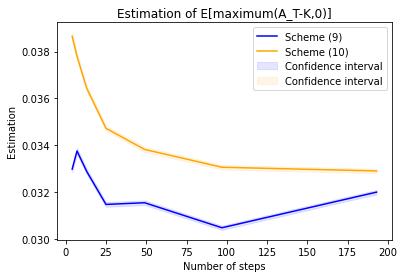

	Estimation of E[f] with Scheme (9) (left) and Scheme (10) (right). The computation time is in seconds.

	Mean Value	 Stat.Error	 Comp.Time	||	 Mean Value	 Stat.Error	 Comp.Time
Ref	 -

n=4	 0.032985	 0.000139	 0.853335	||	 0.038657	 0.000172	 0.949865
n=7	 0.033758	 0.000125	 2.196803	||	 0.037801	 0.000143	 2.378023
n=13	 0.032890	 0.000114	 4.517676	||	 0.036446	 0.000128	 4.780033
n=25	 0.031477	 0.000103	 9.545687	||	 0.034726	 0.000111	 9.721686
n=49	 0.031549	 0.000100	 21.596439	||	 0.033825	 0.000108	 20.056313
n=97	 0.030481	 0.000092	 52.687675	||	 0.033064	 0.000099	 43.752149
n=193	 0.032002	 0.000093	 144.036919	||	 0.032907	 0.000096	 101.651493


In [24]:
plot_estimations(scheme_8_results, scheme_9_results, "E[maximum(A_T-K,0)]") 
show_numerical_results_table(scheme_8_results, scheme_9_results, "-")

## _Lookback option_ maximum(M_T-K,0)


In [25]:
scheme_8_results = scheme_8(lookback_options, S_n_const)
scheme_9_results = scheme_9(lookback_options, S_n_const)

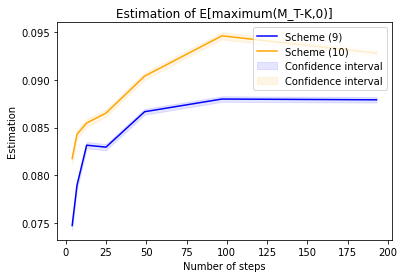

	Estimation of E[f] with Scheme (9) (left) and Scheme (10) (right). The computation time is in seconds.

	Mean Value	 Stat.Error	 Comp.Time	||	 Mean Value	 Stat.Error	 Comp.Time
Ref	 -

n=4	 0.074709	 0.000463	 0.850935	||	 0.081739	 0.000554	 0.944104
n=7	 0.078939	 0.000377	 2.199659	||	 0.084296	 0.000468	 2.457939
n=13	 0.083142	 0.000338	 4.519223	||	 0.085470	 0.000432	 4.780904
n=25	 0.082939	 0.000324	 9.605830	||	 0.086513	 0.000381	 9.694360
n=49	 0.086657	 0.000305	 21.572104	||	 0.090397	 0.000377	 20.178217
n=97	 0.087989	 0.000293	 52.594238	||	 0.094627	 0.000376	 43.831188
n=193	 0.087908	 0.000286	 144.377630	||	 0.092812	 0.000340	 101.947626


In [26]:
plot_estimations(scheme_8_results, scheme_9_results, "E[maximum(M_T-K,0)]")
show_numerical_results_table(scheme_8_results, scheme_9_results, "-")

## _Variance swap price_ E[X_t]

In [27]:
scheme_8_results = scheme_8(variance_swap_price, X_n_const)
scheme_9_results = scheme_9(variance_swap_price, X_n_const)

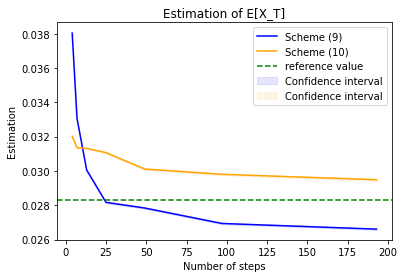

	Estimation of E[f] with Scheme (9) (left) and Scheme (10) (right). The computation time is in seconds.

	Mean Value	 Stat.Error	 Comp.Time	||	 Mean Value	 Stat.Error	 Comp.Time
Ref	 0.028295

n=4	 0.038042	 0.000049	 0.856783	||	 0.032025	 0.000026	 0.936615
n=7	 0.033058	 0.000050	 2.189334	||	 0.031353	 0.000039	 2.348829
n=13	 0.030053	 0.000050	 4.503570	||	 0.031318	 0.000049	 4.772760
n=25	 0.028166	 0.000051	 9.516775	||	 0.031067	 0.000057	 9.647563
n=49	 0.027838	 0.000050	 21.582400	||	 0.030111	 0.000056	 19.975877
n=97	 0.026936	 0.000049	 52.513074	||	 0.029803	 0.000056	 44.369492
n=193	 0.026606	 0.000046	 145.619953	||	 0.029487	 0.000060	 102.407622


In [28]:
plot_estimations(scheme_8_results, scheme_9_results, "E[X_T]", variance_swap_price_ref)
show_numerical_results_table(scheme_8_results, scheme_9_results, variance_swap_price_ref)

## _Variance call price_ E[maximum(X_T-V_0,0)]

In [29]:
scheme_8_results = scheme_8(variance_call_price, X_n_const)
scheme_9_results = scheme_9(variance_call_price, X_n_const)

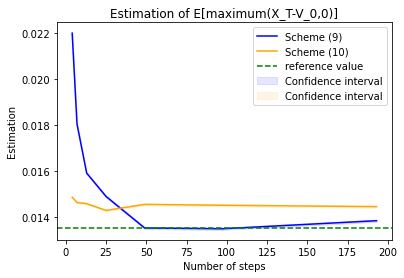

	Estimation of E[f] with Scheme (9) (left) and Scheme (10) (right). The computation time is in seconds.

	Mean Value	 Stat.Error	 Comp.Time	||	 Mean Value	 Stat.Error	 Comp.Time
Ref	 0.013517

n=4	 0.022011	 0.000039	 0.856002	||	 0.014864	 0.000017	 0.937694
n=7	 0.018053	 0.000041	 2.199586	||	 0.014635	 0.000028	 2.363405
n=13	 0.015916	 0.000044	 4.578428	||	 0.014583	 0.000037	 4.751444
n=25	 0.014901	 0.000046	 9.691401	||	 0.014290	 0.000040	 9.598538
n=49	 0.013525	 0.000047	 21.502921	||	 0.014553	 0.000047	 20.051140
n=97	 0.013490	 0.000049	 52.983748	||	 0.014515	 0.000049	 43.749011
n=193	 0.013842	 0.000051	 144.301011	||	 0.014454	 0.000047	 101.465993


In [30]:
plot_estimations(scheme_8_results, scheme_9_results, "E[maximum(X_T-V_0,0)]", variance_call_price_ref)
show_numerical_results_table(scheme_8_results, scheme_9_results, variance_call_price_ref)

## Results for fixed n

In [31]:
n = 200

print(f"n = {n}")
print()
print("Option price\t\t||\tRef\t\t||\t x_1\t\t||\t x_2\t\t||\t |x_1-x_2|")    
print()

european_call_options_8_results = scheme_8(european_call_options, S_n_const, n)
european_call_options_9_results = scheme_9(european_call_options, S_n_const, n)

print(f"European call\t\t||\t",
    f"{european_call_ref}\t||\t",
    f"{european_call_options_8_results['U_M'][0]:f}\t||\t",
    f"{european_call_options_9_results['U_M'][0]:f}\t||\t",
    f"{np.abs(european_call_options_8_results['U_M'][0]-european_call_options_9_results['U_M'][0]):f}\t") 

asian_options_8_results = scheme_8(asian_options, S_n_const, n)
asian_options_9_results = scheme_9(asian_options, S_n_const, n)

print(f"Asian call\t\t||\t",
    f"--\t\t||\t",
    f"{asian_options_8_results['U_M'][0]:f}\t||\t",
    f"{asian_options_9_results['U_M'][0]:f}\t||\t",
    f"{np.abs(asian_options_8_results['U_M'][0]-asian_options_9_results['U_M'][0]):f}\t") 

lookback_options_8_results = scheme_8(lookback_options, S_n_const, n)
lookback_options_9_results = scheme_9(lookback_options, S_n_const, n)

print(f"Lookback call\t\t||\t",
    f"--\t\t||\t",
    f"{lookback_options_8_results['U_M'][0]:f}\t||\t",
    f"{lookback_options_9_results['U_M'][0]:f}\t||\t",
    f"{np.abs(lookback_options_8_results['U_M'][0]-lookback_options_9_results['U_M'][0]):f}\t") 

variance_swap_price_8_results = scheme_8(variance_swap_price, X_n_const, n)
variance_swap_price_9_results = scheme_9(variance_swap_price, X_n_const, n)

print(f"Variance swap call\t||\t",
    f"{variance_swap_price_ref}\t||\t",
    f"{variance_swap_price_8_results['U_M'][0]:f}\t||\t",
    f"{variance_swap_price_9_results['U_M'][0]:f}\t||\t",
    f"{np.abs(variance_swap_price_8_results['U_M'][0]-variance_swap_price_9_results['U_M'][0]):f}\t") 

variance_call_price_8_results = scheme_8(variance_call_price, X_n_const, n)
variance_call_price_9_results = scheme_9(variance_call_price, X_n_const, n)

print(f"Variance call\t\t||\t",
    f"{variance_call_price_ref}\t||\t",
    f"{variance_call_price_8_results['U_M'][0]:f}\t||\t",
    f"{variance_call_price_9_results['U_M'][0]:f}\t||\t",
    f"{np.abs(variance_call_price_8_results['U_M'][0]-variance_call_price_9_results['U_M'][0]):f}\t")

n = 200

Option price		||	Ref		||	 x_1		||	 x_2		||	 |x_1-x_2|

European call		||	 0.056832	||	 0.057340	||	 0.059583	||	 0.002243	
Asian call		||	 --		||	 0.031498	||	 0.031963	||	 0.000465	
Lookback call		||	 --		||	 0.090644	||	 0.094516	||	 0.003872	
Variance swap call	||	 0.028295	||	 0.029756	||	 0.029158	||	 0.000598	
Variance call		||	 0.013517	||	 0.013283	||	 0.012960	||	 0.000323	


In [32]:
# Display previous results without recalculating

print(f"n = {n}")
print()
print("Option price\t\t||\tRef\t\t||\t\t x_1\t\t||\t x_2\t\t\t||")    
print()

print(f"European call\t\t||\t",
    f"{european_call_ref}\t||\t",
    f"{european_call_options_8_results['U_M'][0]:f}+-{european_call_options_8_results['error'][0]:f}\t||\t",
    f"{european_call_options_9_results['U_M'][0]:f}+-{european_call_options_9_results['error'][0]:f}\t||\t") 
print(f"E[maximum(S_T-K,0)]\n")

print(f"Asian call\t\t||\t",
    f"--\t\t||\t",
    f"{asian_options_8_results['U_M'][0]:f}+-{asian_options_8_results['error'][0]:f}\t||\t",
    f"{asian_options_9_results['U_M'][0]:f}+-{asian_options_9_results['error'][0]:f}\t||\t") 
print(f"E[maximum(A_T-K,0)]\n")

print(f"Lookback call\t\t||\t",
    f"--\t\t||\t",
    f"{lookback_options_8_results['U_M'][0]:f}+-{lookback_options_8_results['error'][0]:f}\t||\t",
    f"{lookback_options_9_results['U_M'][0]:f}+-{lookback_options_9_results['error'][0]:f}\t||\t") 
print(f"E[maximum(M_T-K,0)]\n")

print(f"Variance swap call\t||\t",
    f"{variance_swap_price_ref}\t||\t",
    f"{variance_swap_price_8_results['U_M'][0]:f}+-{variance_swap_price_8_results['error'][0]:f}\t||\t",
    f"{variance_swap_price_9_results['U_M'][0]:f}+-{variance_swap_price_9_results['error'][0]:f}\t||\t") 
print(f"E[X_T]\n")

print(f"Variance call\t\t||\t",
    f"{variance_call_price_ref}\t||\t",
    f"{variance_call_price_8_results['U_M'][0]:f}+-{variance_call_price_8_results['error'][0]:f}\t||\t",
    f"{variance_call_price_9_results['U_M'][0]:f}+-{variance_call_price_9_results['error'][0]:f}\t||\t")
print(f"E[maximum(X_T-V_0,0)]\n")

n = 200

Option price		||	Ref		||		 x_1		||	 x_2			||

European call		||	 0.056832	||	 0.057340+-0.000348	||	 0.059583+-0.000366	||	
E[maximum(S_T-K,0)]

Asian call		||	 --		||	 0.031498+-0.000092	||	 0.031963+-0.000093	||	
E[maximum(A_T-K,0)]

Lookback call		||	 --		||	 0.090644+-0.000319	||	 0.094516+-0.000337	||	
E[maximum(M_T-K,0)]

Variance swap call	||	 0.028295	||	 0.029756+-0.000067	||	 0.029158+-0.000056	||	
E[X_T]

Variance call		||	 0.013517	||	 0.013283+-0.000041	||	 0.012960+-0.000044	||	
E[maximum(X_T-V_0,0)]

